In [2]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import math
import copy as cp
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
train=pd.read_csv("../data/first_round_training_data.csv")
#train['Parameter2'] = train['Parameter2'].apply(lambda x：50000 if x>50000 else x)
#train['Parameter2'] = train['Parameter2'].apply(lambda x：0.0005 if x<0.0005 else x)
#train['Parameter2'] = train['Parameter2'].apply(lambda x: 50000 if x > 50000 else x)
#train['Parameter2'] = train['Parameter2'].apply(lambda x: 0.0005 if x < 0.0005 else x)
#train = train.fillna(0)
#bins = [0, 0.1, 1, 8,100,1000000]
#train['A4'] = pd.cut(train['Attribute4'],bins,labels={'0','1','2','3','4'}).astype(int)
#train['A5'] = pd.cut(train['Attribute5'],bins,labels={'0','1','2','3','4'}).astype(int)
#train['A6'] = pd.cut(train['Attribute6'],bins,labels={'0','1','2','3','4'}).astype(int)
#train['A7'] = pd.cut(train['Attribute7'],bins,labels={'0','1','2','3','4'}).astype(int)
#train['A8'] = pd.cut(train['Attribute8'],bins,labels={'0','1','2','3','4'}).astype(int)
#train['A9'] = pd.cut(train['Attribute9'],bins,labels={'0','1','2','3','4'})
#train = train.fillna(0)
#train['A10'] = pd.cut(train['Attribute10'],bins,labels={'0','1','2','3','4'}).astype(int)

test=pd.read_csv("../data_3/second_round_testing_data.csv")
#train = train.drop_duplicates(['Parameter5','Parameter7','Parameter8','Parameter9','Parameter10','Attribute4','Attribute5','Attribute6','Attribute7','Attribute8','Attribute9','Attribute10'],'first')
#来做特征啦啦
data = train.append(test).reset_index(drop=True)
dit = {'Excellent':0,'Good':1,'Pass':2,'Fail':3}
data['label'] = data['Quality_label'].map(dit)
train['label'] = train['Quality_label'].map(dit)
del data['Quality_label']
data = data.fillna(-1)
#取对数，用处不大

m = data.groupby(['Parameter7'])['label'].count().reset_index(name='count7')
data = data.merge(m)
m = data.groupby(['Parameter8'])['label'].count().reset_index(name='count8')
data = data.merge(m)
#m = data.groupby(['Parameter9'])['label'].count().reset_index(name='count9')
#data = data.merge(m)
m = data.groupby(['Parameter10'])['label'].count().reset_index(name='count10')
data = data.merge(m)


m = data.groupby(['Parameter10'])['label'].mean().rank().reset_index(name='rank10')
data = data.merge(m)


data['moby'] = data['Parameter7']/(data['Parameter5']+data['Parameter6']+data['Parameter8'])
data['moby2'] = data['Parameter10']/(data['Parameter5']+data['Parameter6']+data['Parameter8']+data['Parameter9'])
data['moby3'] = data['Parameter8']/(data['Parameter5']+data['Parameter6']+data['Parameter7']+data['Parameter8']+data['Parameter9']+data['Parameter10'])
#data['Parameter2'] = data['Parameter2'].apply(lambda x: 50000 if x > 50000 else x)
feature = [f for f in data.columns if f not in ['Parameter1','Parameter4','label','Group','Attribute1','Attribute2','Attribute3','Attribute4','Attribute5','Attribute6','Attribute7','Attribute8','Attribute9','Attribute10']]

data = data.fillna(-1)
train = data.loc[data.label>=0]
test = data.loc[data.label<0]
test = test.sort_values(by=['Group'], ascending=True)
label = train['label']

train_x = train[feature]

train_y = train['label']
test_id = test['Group']
test_x = test[feature]

params = {
'boosting_type': 'gbdt',
'objective': 'multiclassova',
'num_class': 4,  
'metric': 'multi_error', 
'num_leaves': 63,
'learning_rate': 0.01,
'feature_fraction': 0.9,
'bagging_fraction': 0.9,
'bagging_seed':93926,
'bagging_freq': 1,
'verbose': -1,
'reg_alpha':1,
'reg_lambda':2,
'lambda_l1': 1,
'lambda_l2': 0,
'num_threads': 8,
}
lgb_train = lgb.Dataset(train_x, train_y)

#自定义目标函数

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1200,
                valid_sets=[lgb_train],
                valid_names=['train'],
                verbose_eval=100
                )


/home/zsy/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


[100]	train's multi_error: 0.369667
[200]	train's multi_error: 0.338833
[300]	train's multi_error: 0.299833
[400]	train's multi_error: 0.261667
[500]	train's multi_error: 0.224
[600]	train's multi_error: 0.19
[700]	train's multi_error: 0.1685
[800]	train's multi_error: 0.144
[900]	train's multi_error: 0.121833
[1000]	train's multi_error: 0.100333
[1100]	train's multi_error: 0.0836667
[1200]	train's multi_error: 0.0716667


In [2]:
ans=gbm.predict(test_x, num_iteration=1300)

In [3]:
test_sub = pd.read_csv('../data/first_round_testing_data.csv')
submit = pd.read_csv('../data/submit_example.csv')
sub = test_sub[['Group']]

prob_cols = [i for i in submit.columns if i not in ['Group']]

for i, f in enumerate(prob_cols):
    sub[f] = ans[:, i]

/home/zsy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
sub.to_csv('lgb_cao_best.csv',index = False)

In [ ]:
f=open("F:/lgb1.csv","w")
ans=gbm.predict(test_x, num_iteration=1300)
tmp=np.zeros([120,4])
cnt=np.zeros([120])
test_id = np.array(test_id)
for i in range(6000):
    ID=test_id[i]
    ID = int(ID)
    tmp[ID,:]+=ans[i,:]
    cnt[ID]+=1
for i in range(120):
    SUM=np.sum(tmp[i,:])
    tmp[i,:]/=SUM

f.write("Group,Excellent ratio,Good ratio,Pass ratio,Fail ratio\n")
for i in range(120):
    f.write(str(i))
    for j in range(4):
        f.write(","+str(tmp[i,j]))
    f.write("\n")
f.close()

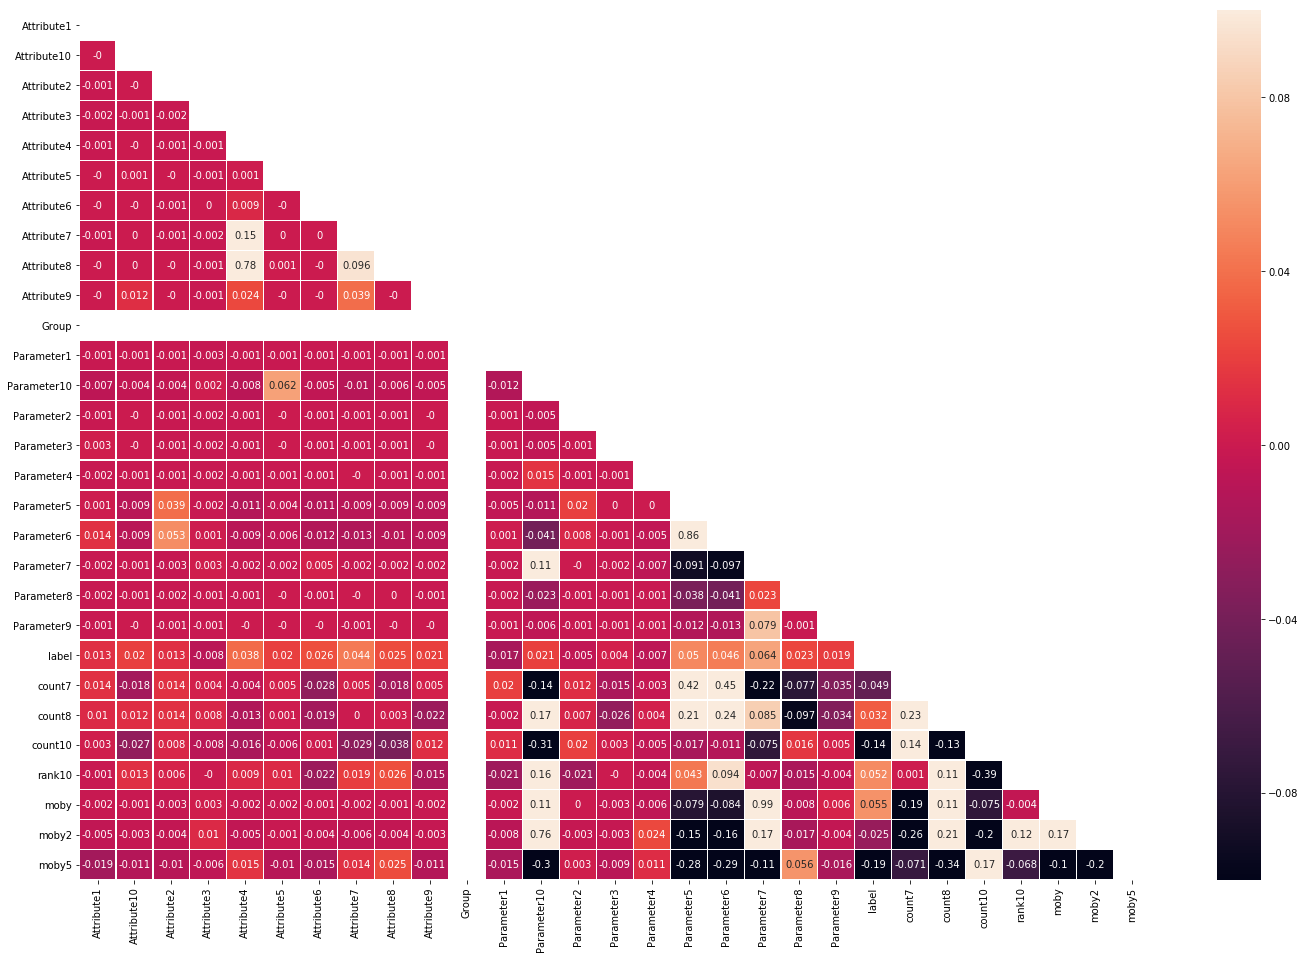

In [2]:
plt.figure(figsize=(24,16))
correlation = train.corr()
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=correlation.round(3),mask=mask,vmin=-0.1,vmax=0.1,annot=True, linewidths=.1)

In [1]:
data['Parameter2']

NameError: name 'data' is not defined

In [ ]:
1. 去掉P10排序，换成分布更好的P7，P8下降
2. moby2 下降
3. 